In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import random
from sklearn.model_selection import train_test_split

SAMPLE_RATE = 22050
DURATION = 2
SAMPLES_PER_CLIP = SAMPLE_RATE * DURATION
NUM_SAMPLES_PER_CLASS = 100
NUM_MFCC = 13
N_MFCC_TIME_STEPS = 50

def generate_sine_wave(frequency, duration, sample_rate):
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    tone = 0.5 * np.sin(2 * np.pi * frequency * t)
    return tone

def generate_deepfake_like_audio():
    base = generate_sine_wave(300 + random.randint(0, 100), DURATION, SAMPLE_RATE)
    noise = np.random.normal(0, 0.1, base.shape)
    return base + noise

def generate_bonafide_like_audio():
    return generate_sine_wave(200 + random.randint(0, 50), DURATION, SAMPLE_RATE)

def extract_mfcc(audio):
    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=NUM_MFCC)
    if mfcc.shape[1] < N_MFCC_TIME_STEPS:
        pad_width = N_MFCC_TIME_STEPS - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :N_MFCC_TIME_STEPS]
    return mfcc.flatten()

data = []
labels = []

for _ in range(NUM_SAMPLES_PER_CLASS):
    bonafide = generate_bonafide_like_audio()
    deepfake = generate_deepfake_like_audio()

    mfcc_bona = extract_mfcc(bonafide)
    mfcc_fake = extract_mfcc(deepfake)

    data.append(mfcc_bona)
    labels.append(0)  # Bonafide

    data.append(mfcc_fake)
    labels.append(1)  # Deepfake

X = np.array(data)
y = np.array(labels)

df = pd.DataFrame(X)
df['label'] = y

df.to_csv('synthetic_urdu_deepfake_audio.csv', index=False)

print("Dataset shape:", df.shape)
print("Sample rows:\n", df.head())


Dataset shape: (200, 651)
Sample rows:
             0           1           2           3           4           5  \
0 -291.147327 -338.577916 -483.514707 -483.500845 -483.453923 -483.534892   
1  -30.786926   -6.770281  -15.913709  -17.111204  -17.085596  -15.423644   
2 -288.257609 -336.974018 -485.246416 -485.161234 -485.167625 -485.262525   
3  -19.827786   -4.213956  -17.687435  -15.774981  -14.954506  -15.244355   
4 -292.372714 -340.027061 -496.201925 -496.202743 -496.201927 -496.202740   

            6           7           8           9  ...        641        642  \
0 -483.413980 -483.526648 -483.487046 -483.486801  ... -29.548683 -29.501307   
1  -15.740154  -15.000343  -14.344713  -13.411948  ... -11.089780 -14.768333   
2 -485.389958 -485.440535 -485.359115 -485.231152  ... -33.830296 -33.789203   
3  -15.107350  -19.881220  -19.487735  -14.024034  ...  -8.338343 -11.185304   
4 -496.201930 -496.202736 -496.201935 -496.202730  ... -22.386749 -22.387333   

         643    

In [2]:
pip install scikit-learn matplotlib

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt


In [4]:
# Load the saved synthetic dataset
df = pd.read_csv('synthetic_urdu_deepfake_audio.csv')

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (200, 651)


,0,1,2,3,4,5,6,7,8,9,...,641,642,643,644,645,646,647,648,649,label
0,-291.147327,-338.577916,-483.514707,-483.500845,-483.453923,-483.534892,-483.413980,-483.526648,-483.487046,-483.486801,...,-29.548683,-29.501307,-29.499767,-29.549820,-29.417609,-29.558511,-29.465263,-29.516922,-29.535715,0
1,-30.786926,-6.770281,-15.913709,-17.111204,-17.085596,-15.423644,-15.740154,-15.000343,-14.344713,-13.411948,...,-11.089780,-14.768333,-12.280709,-8.515572,-7.113719,-12.145496,-12.338447,-11.434053,-8.276103,1
2,-288.257609,-336.974018,-485.246416,-485.161234,-485.167625,-485.262525,-485.389958,-485.440535,-485.359115,-485.231152,...,-33.830296,-33.789203,-33.657545,-33.550260,-33.534547,-33.618594,-33.753860,-33.833327,-33.774589,0
3,-19.827786,-4.213956,-17.687435,-15.774981,-14.954506,-15.244355,-15.107350,-19.881220,-19.487735,-14.024034,...,-8.338343,-11.185304,-11.737201,-8.251779,-5.693657,-6.415765,-8.586073,-13.123850,-12.247407,1
4,-292.372714,-340.027061,-496.201925,-496.202743,-496.201927,-496.202740,-496.201930,-496.202736,-496.201935,-496.202730,...,-22.386749,-22.387333,-22.386791,-22.387289,-22.386835,-22.387245,-22.386879,-22.387201,-22.386924,0


In [5]:
# Separate input features and target labels
X = df.drop('label', axis=1)
y = df['label']


In [6]:
# 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 140, Testing samples: 60


In [7]:
# Normalize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# Define models
models = {
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Single-Layer Perceptron": MLPClassifier(hidden_layer_sizes=(20,), max_iter=500, random_state=42)
}


In [9]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"

    print(f"\n{name} Evaluation:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc}")


In [10]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    evaluate_model(name, model, X_test_scaled, y_test)



Training SVM...

SVM Evaluation:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
AUC-ROC:   0.9999999999999999

Training Logistic Regression...

Logistic Regression Evaluation:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
AUC-ROC:   1.0

Training Single-Layer Perceptron...

Single-Layer Perceptron Evaluation:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
AUC-ROC:   1.0


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [12]:
y_train_float = y_train.astype('float32')
y_test_float = y_test.astype('float32')


In [13]:
# Define a simple DNN with 2 hidden layers
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [15]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_float,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8368 - loss: 0.3832 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 1.5282e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 9.7654e-05 - val_accuracy: 1.0000 - val_loss: 5.0303e-05
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.6519e-05 - val_accuracy: 1.0000 - val_loss: 2.7459e-05
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 8.8545e-06 - val_accuracy: 1.0000 - val_loss: 1.9511e-05
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 3.6442e-05 - val_accuracy: 1.0000 - val_loss: 1.6183e-05
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.9761e-05 - val_accuracy: 1.0000 - val_loss: 1.4602e-05
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - los

In [16]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict probabilities and convert to binary
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Evaluate
print("\nDNN Classification Report:")
print(classification_report(y_test, y_pred_class))

# AUC-ROC
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"DNN AUC-ROC: {auc_score:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

DNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

DNN AUC-ROC: 1.0000


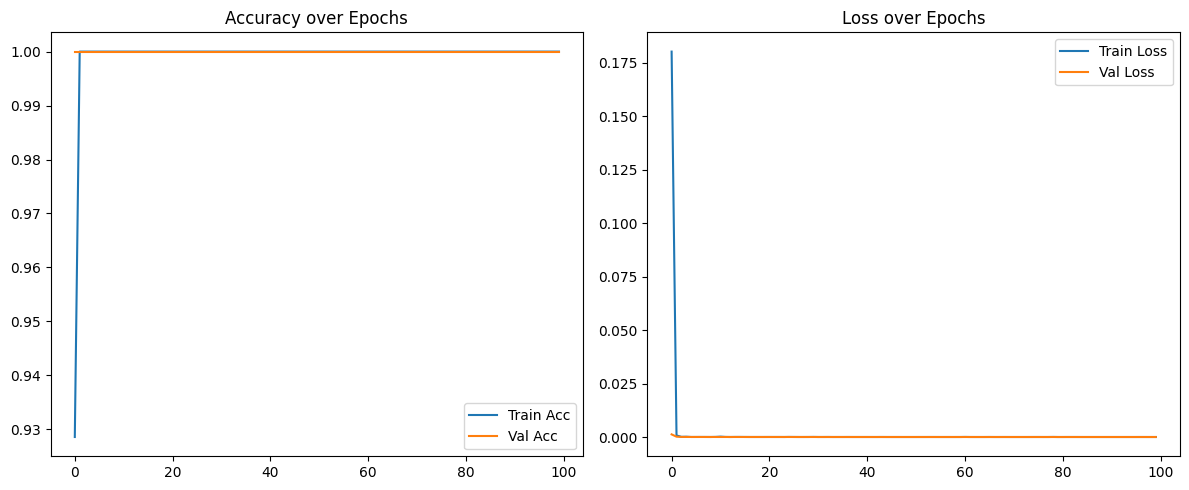

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
# Save model to file
model.save("deepfake_dnn_model.h5")
print("Model saved as deepfake_dnn_model.h5")


Model saved as deepfake_dnn_model.h5


In [19]:
# Collect results in a dictionary
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "AUC-ROC": []
}

def add_results(name, y_true, y_pred, y_prob):
    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(y_true, y_pred))
    results["Precision"].append(precision_score(y_true, y_pred))
    results["Recall"].append(recall_score(y_true, y_pred))
    results["F1-Score"].append(f1_score(y_true, y_pred))
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    results["AUC-ROC"].append(auc)

# Classical models
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    add_results(name, y_test, y_pred, y_prob)

# DNN
add_results("DNN", y_pred_class, y_test, y_pred_prob)

# Create DataFrame
results_df = pd.DataFrame(results)
print("\n🔍 Model Comparison Summary:")
display(results_df)



🔍 Model Comparison Summary:


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,SVM,1.0,1.0,1.0,1.0,1.0
1,Logistic Regression,1.0,1.0,1.0,1.0,1.0
2,Single-Layer Perceptron,1.0,1.0,1.0,1.0,1.0
3,DNN,1.0,1.0,1.0,1.0,1.0
